# Projeto de Business Analytics - Previsão de Vendas
## Base de dados de 185mil registros
### Gerar previsão de vendas de 3 meses do produto mais vendido dos últimos 2 anos
### Objetivo:
#### Criar um modelo de previsão de vendas para promover uma melhor gestão de estoques
#### O modelo proposto poderá ser utilizado:
- Base total de produtos, ou considerar 80/20 dos resultados de vendas
- Plugar os coeficientes na ERP para cálculo automáticvo de pedidos de compras

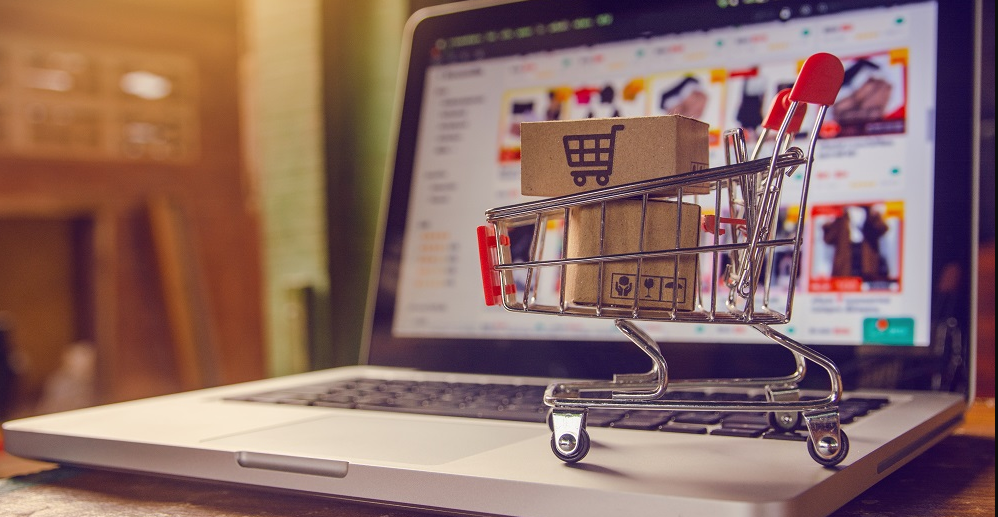

In [1]:
from IPython.display import Image
Image('ecommerce.png')

In [3]:
# Imports

# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.plotting import autocorrelation_plot
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame

# ARIMA
from statsmodels.tsa.arima.model import ARIMA

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings('ignore')

# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

plotly    : 5.9.0
numpy     : 1.23.5
seaborn   : 0.12.2
matplotlib: 3.7.1
sys       : 3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]
pandas    : 1.5.3



In [4]:
# importar base de dados
df = pd.read_csv('vendas_eletronicos_2nos.csv')

In [5]:
# verificar shape
df.shape

(185950, 9)

In [6]:
# verificar tipos de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185950 entries, 0 to 185949
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   data       185950 non-null  object 
 1   venda_id   185950 non-null  int64  
 2   cliente    185950 non-null  int64  
 3   cidade     185950 non-null  object 
 4   produto    185950 non-null  object 
 5   categoria  185950 non-null  object 
 6   qtd        185950 non-null  int64  
 7   preco      185950 non-null  float64
 8   venda      185950 non-null  float64
dtypes: float64(2), int64(3), object(4)
memory usage: 12.8+ MB


In [7]:
# transformar dados da coluna data
df['data'] = pd.to_datetime(df['data'])

In [8]:
# transformar dados em string
df = df.astype({'venda_id': 'object', 'cliente': 'object'})

In [9]:
# verificxar tipos de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185950 entries, 0 to 185949
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   data       185950 non-null  datetime64[ns]
 1   venda_id   185950 non-null  object        
 2   cliente    185950 non-null  object        
 3   cidade     185950 non-null  object        
 4   produto    185950 non-null  object        
 5   categoria  185950 non-null  object        
 6   qtd        185950 non-null  int64         
 7   preco      185950 non-null  float64       
 8   venda      185950 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 12.8+ MB


In [10]:
# amostra dos dados
df.sample(10)

,data,venda_id,cliente,cidade,produto,categoria,qtd,preco,venda
141609,2020-08-02 16:54:00,242153,431590,GUARULHOS,FONES DE OUVIDO COM FIO,ACESSORIOS,1,11.99,11.99
98568,2020-02-20 00:05:00,159241,467040,SAO BERNARDO,CABO DE CARREGAMENTO USB-C,ACESSORIOS,1,11.95,11.95
53254,2019-08-31 22:55:00,237864,292980,SAO CAETANO,GOOGLE PHONE,ELETRONICOS,1,600.00,600.00
152531,2020-09-26 12:26:00,257422,181190,BARUERI,"MONITOR FHD DE 27""",ELETRONICOS,1,149.99,149.99
128438,2020-06-07 18:55:00,217184,306140,CARAPICUIBA,NOTEBOOK MACBOOK PRO,ELETRONICOS,1,1700.00,1700.00
116824,2020-04-26 21:09:00,186321,171450,SAO PAULO,"MONITOR FHD DE 27""",ELETRONICOS,1,149.99,149.99
28382,2019-05-09 17:02:00,201751,255360,SAO BERNARDO,CABO DE CARREGAMENTO LIGHTNING,ACESSORIOS,1,14.95,14.95
31213,2019-05-20 16:15:00,196056,301380,SAO CAETANO,FONES DE OUVIDO COM FIO,ACESSORIOS,1,11.99,11.99
70038,2019-11-05 23:47:00,288259,265830,SAO PAULO,CABO DE CARREGAMENTO LIGHTNING,ACESSORIOS,1,14.95,14.95
25815,2019-04-29 16:07:00,191687,290990,DIADEMA,FLATSCREEN TV,ELETRONICOS,1,300.00,300.00


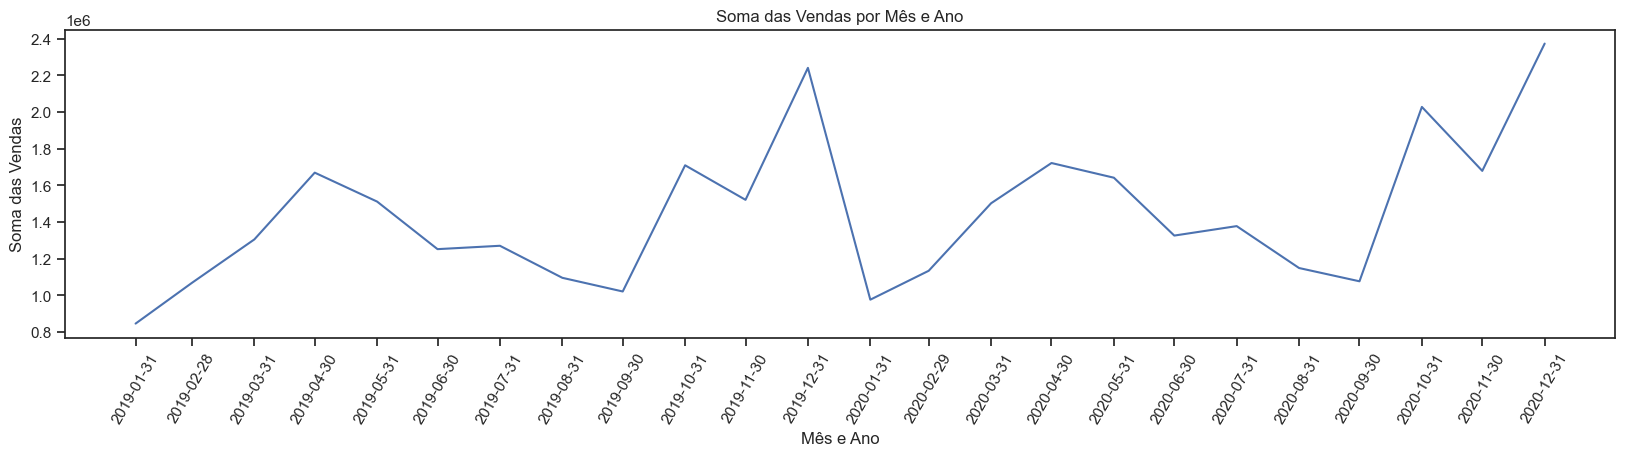

In [11]:
# Vendas totais mês a mês
df_grouped = df.resample('M', on='data').sum()
df_grouped = df_grouped.reset_index()

# Plotar o gráfico de linhas com Seaborn
sns.set(style="ticks")
plt.figure(figsize=(20, 4))
sns.lineplot(x="data", y="venda", data=df_grouped)
plt.xlabel('Mês e Ano')
plt.ylabel('Soma das Vendas')
plt.title('Soma das Vendas por Mês e Ano')
plt.xticks(df_grouped['data'], rotation=60)
plt.show()

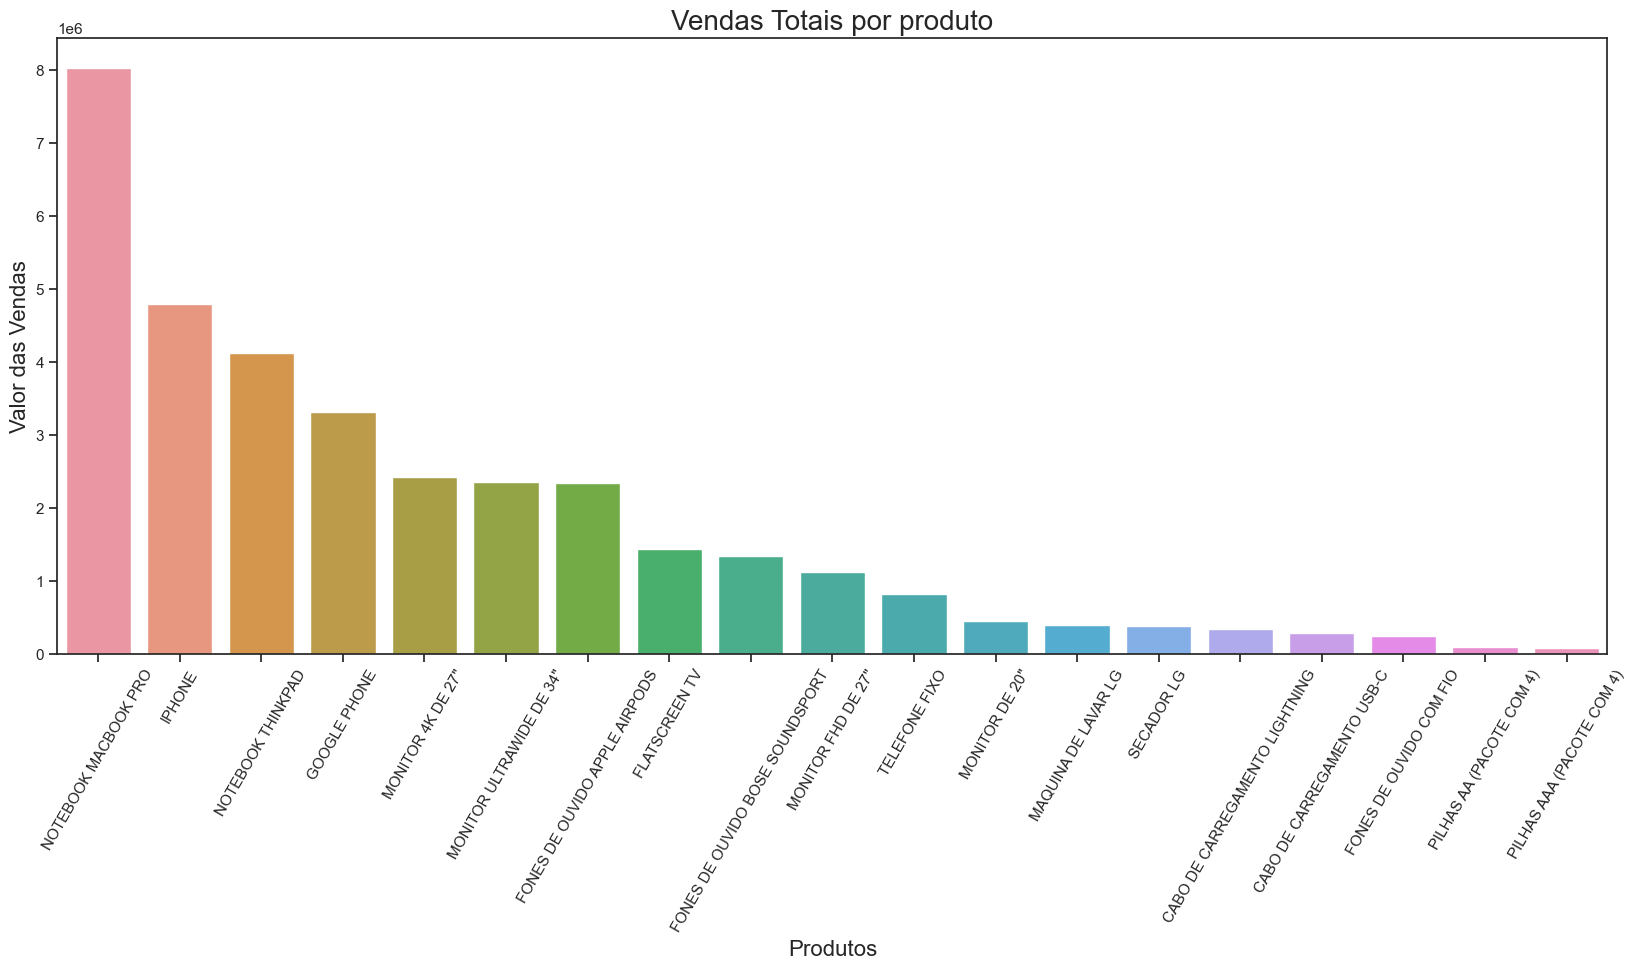

In [12]:
# Plotar o gráfico de vendas de produtos
ag_cidade = df.groupby(['produto']).agg({'qtd': 'sum', 'venda': 'sum'}).sort_values(by='venda',ascending=False).reset_index()

sns.set(style="ticks")
plt.figure(figsize=(20, 8))
sns.barplot(x="produto", y="venda", data=ag_cidade)
plt.xlabel('Produtos', fontsize=16)    # Tamanho da letra do xlabel definido como 16
plt.ylabel('Valor das Vendas', fontsize=16)    # Tamanho da letra do ylabel definido como 16
plt.title('Vendas Totais por produto', fontsize=20)    # Tamanho da letra do título definido como 20
plt.xticks(rotation=60)
plt.show()

In [13]:
# produto mais vendido
ag_cidade.iloc[:1]

,produto,qtd,venda
0,NOTEBOOK MACBOOK PRO,4728,8037600.0


## Desenvolvimento do Modelo


In [14]:
# Filtrar o DataFrame original 'df' pela categoria 'NOTEBOOK MACBOOK PRO'
pdt = df[df['produto'] == 'NOTEBOOK MACBOOK PRO']
pdt = pdt[['data', 'qtd']]
pdt = pdt.resample('M', on='data').sum()

In [15]:
# amostras dos dados de qtd
pdt.head()

,qtd
data,
2019-01-31,115
2019-02-28,138
2019-03-31,170
2019-04-30,237
2019-05-31,217


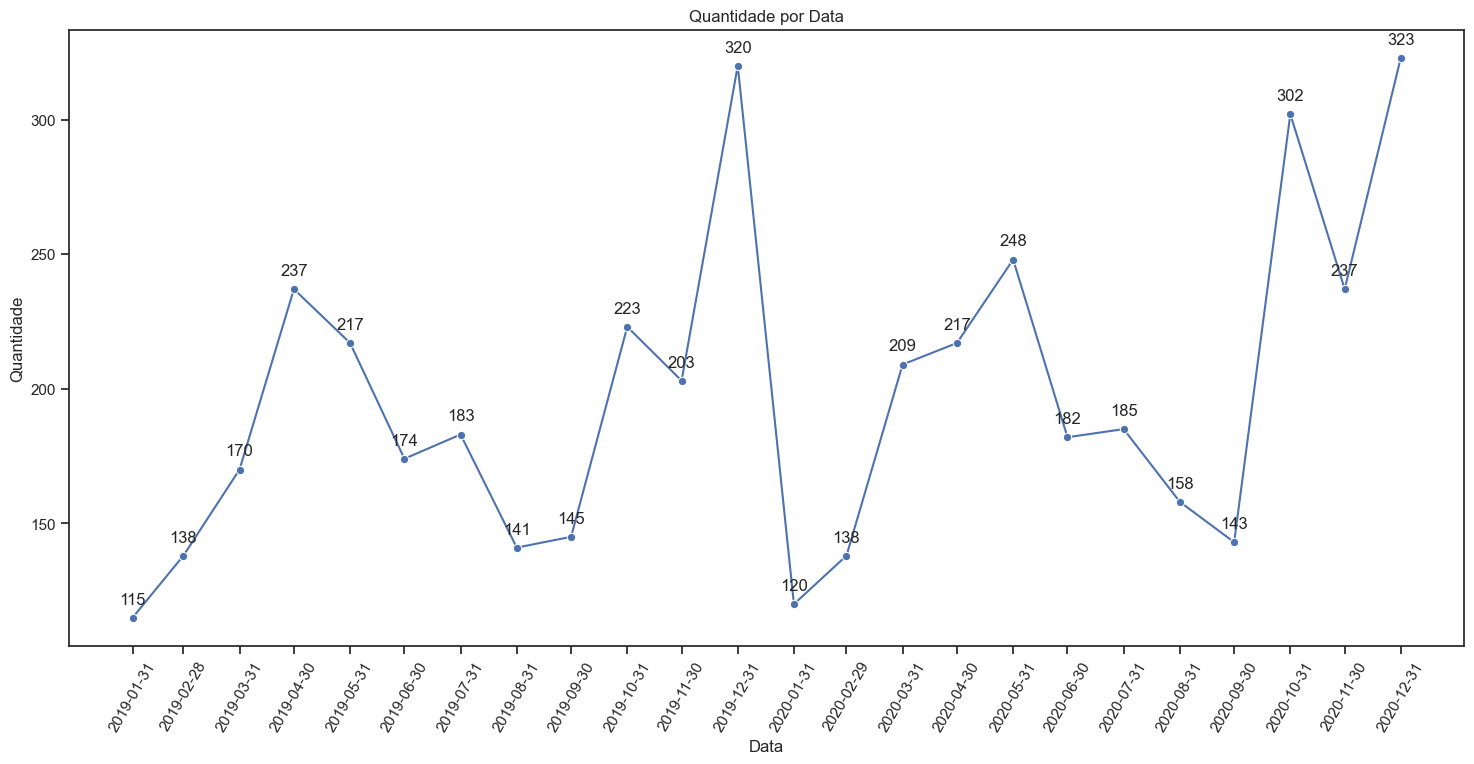

In [16]:
# Criar o gráfico de linhas
plt.figure(figsize=(18, 8))
sns.lineplot(x=pdt.index, y='qtd', data=pdt, marker='o')

# Adicionar números nos pontos das linhas
for x, y in zip(pdt.index, pdt['qtd']):
    plt.annotate(y, (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Configurações adicionais
plt.title('Quantidade por Data')
plt.xlabel('Data')
plt.ylabel('Quantidade')

# Formatar rótulos do eixo x
date_labels = pdt.index.strftime('%Y-%m-%d')
plt.xticks(pdt.index, date_labels, rotation=60)

# Exibir o gráfico
plt.show()

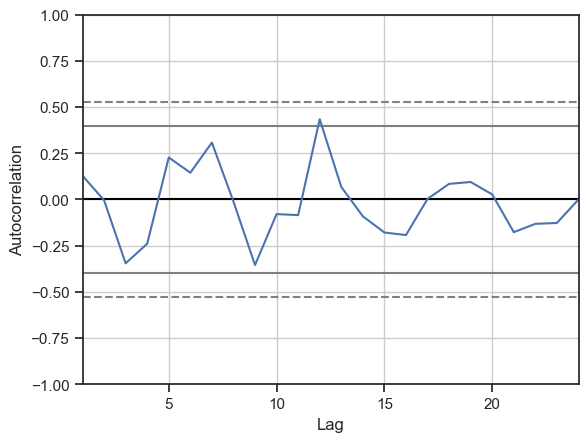

In [17]:
# autocorrelação plot
autocorrelation_plot(pdt)
plt.show()

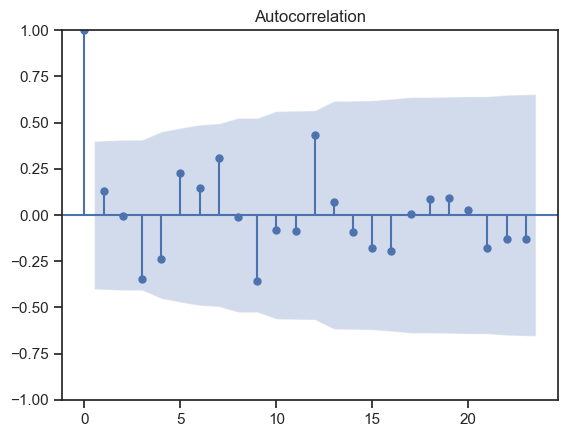

In [18]:
# Outra forma de autocorrelação
plot_acf(pdt, lags=23)
plt.show()

In [19]:
# Cria o modelo ARIMA
model = ARIMA(pdt, order=(24, 1, 12))  # Parâmetros (p, d, q) do ARIMA

# Ajusta o modelo aos dados
model_fit = model.fit()

In [20]:
# summary 
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    qtd   No. Observations:                   24
Model:               ARIMA(24, 1, 12)   Log Likelihood                -109.211
Date:                Fri, 02 Jun 2023   AIC                            292.423
Time:                        11:06:52   BIC                            334.436
Sample:                    01-31-2019   HQIC                           302.989
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3388      5.740     -0.059      0.953     -11.589      10.911
ar.L2         -1.1833     15.600     -0.076      0.940     -31.758      29.392
ar.L3         -0.4160     14.909     -0.028      0.9

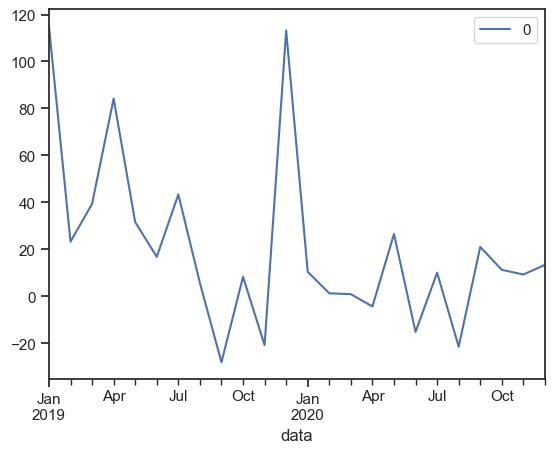

In [21]:
# plot residuais
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

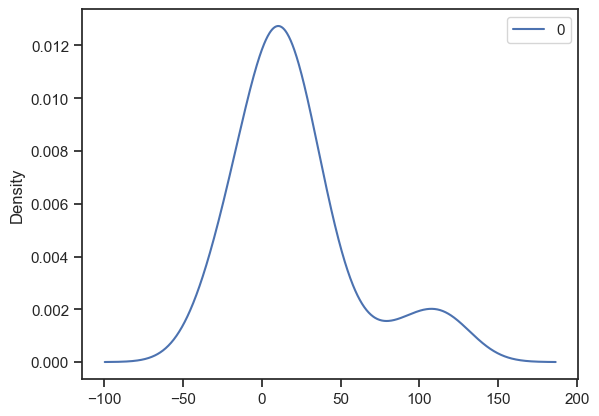

In [22]:
# gráficos de densidade dos residuais
residuals.plot(kind='kde')
plt.show()

In [23]:
# estatística descritiva dos residuos
print(residuals.describe())

                0
count   24.000000
mean    20.613464
std     37.278719
min    -28.105709
25%      1.165522
50%     10.833869
75%     27.781066
max    115.000000


In [24]:
previsao = model_fit.predict(start='2021-01-31', end='2021-03-31')

In [25]:
previsao = pd.DataFrame(previsao)

In [26]:
# Renomear a coluna 'predicted_mean' para 'qtd'
previsao.rename(columns={'predicted_mean': 'qtd'}, inplace=True)


# Definir o nome da coluna de índice como 'data'
previsao.index.name = 'data'

# Converter os valores da coluna 'qtd_prev' de float para int
previsao['qtd'] = previsao['qtd'].astype(int)

previsao

,qtd
data,
2021-01-31,127
2021-02-28,118
2021-03-31,270


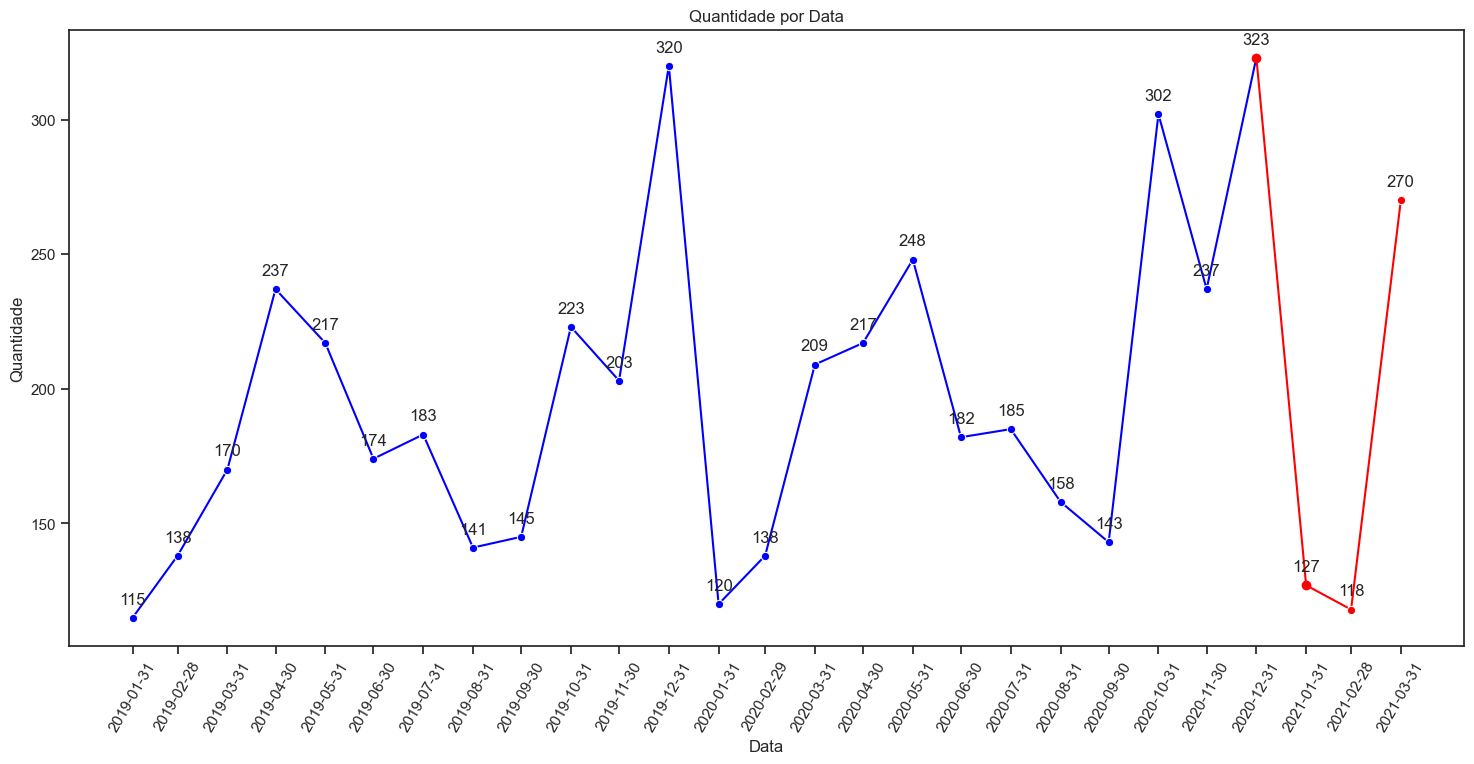

In [27]:
# Concatenar os dataframes pdt e previsao
combined_df = pd.concat([pdt, previsao])

# Criar o gráfico de linhas
plt.figure(figsize=(18, 8))

# Plotar a linha do dataset pdt em azul
sns.lineplot(x=pdt.index, y='qtd', data=pdt, marker='o', color='blue')

# Plotar a linha do dataset previsao em vermelho
sns.lineplot(x=previsao.index, y='qtd', data=previsao, marker='o', color='red')

# Adicionar números nos pontos das linhas
for x, y in zip(combined_df.index, combined_df['qtd']):
    plt.annotate(y, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Obter os valores da última data do pdt e a primeira data do previsao
last_pdt_date = pdt.index[-1]
first_previsao_date = previsao.index[0]

# Adicionar linha contínua para conectar as linhas
plt.plot([last_pdt_date, first_previsao_date], [pdt.loc[last_pdt_date, 'qtd'], previsao.loc[first_previsao_date, 'qtd']],
         marker='o', color='red', linestyle='-')

# Configurações adicionais
plt.title('Quantidade por Data')
plt.xlabel('Data')
plt.ylabel('Quantidade')

# Formatar rótulos do eixo x
date_labels = combined_df.index.strftime('%Y-%m-%d')
plt.xticks(combined_df.index, date_labels, rotation=60)

# Exibir o gráfico
plt.show()

### Parecer Final
- Modelo de média acurácia devido ao curto espaço de tempo.
- Base dados ideal seria com informações de pelo menos 3 anos

## Fim